Variational Autoencoder Implementation
==

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import clear_output
import sys
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNIST original', data_home='.')
print mnist.data.shape


(70000, 784)


In [159]:
def matmul(X, dout, name):
    with tf.variable_scope(name):
        _, dX = X.get_shape()
        W = tf.get_variable('W', shape=(dX, dout))
        b = tf.get_variable('b', shape=(dout))
    return tf.matmul(X, W)+b


def relu_layer(X, dout, name):
    return tf.nn.relu(matmul(X, dout, name))


class VAE(object):
    def __init__(self, dX, dZ):
        self.enc_layers = [512]
        self.dec_layers = [512]
        self.dZ = dZ
        self.dX = dX

        self._build_network(dX, dZ)
        self._init_tf()

    def _build_network(self, dX, dZ):

        self.X = X = tf.placeholder(tf.float32, shape=(None, dX), name='X')
        self.noise = tf.placeholder(tf.float32, shape=(None, dZ), name='Z')
        self.lr = tf.placeholder(tf.float32, shape=tuple(), name='lr')

        # Encoding
        encoding = self.X
        with tf.variable_scope('encoder'):
            for i, layer_size in enumerate(self.enc_layers):
                encoding = relu_layer(encoding, layer_size, name='enc_%d'%i)
            # make mu, sigma
            self.mu = mu_enc = matmul(encoding, dZ, name='enc_mu')
            self.log_sigma = log_sigma_enc = matmul(encoding, dZ, name='enc_sig')
        
        self.sigma = sigma_enc = tf.exp(log_sigma_enc)
        #sigma_enc = tf.Print(sigma_enc, [sigma_enc], message='sigma_enc', summarize=20)
        #mu_enc = tf.Print(mu_enc, [mu_enc], message='mu_enc', summarize=20)

        # Decoding
        enc_output = self.noise*tf.sqrt(sigma_enc) + mu_enc
        mu_dec = self._decode(enc_output)
        #mu_dec = tf.Print(mu_dec, [mu_dec], message='mu_dec', summarize=20)
        #X = tf.Print(self.X, [self.X], message='x', summarize=20)
        self.mu_dec = mu_dec
        
        # Sample decode
        self.sample_Z = tf.placeholder(tf.float32, shape=(None, dZ), name='Z_sample')
        self.sample_mu = self._decode(self.sample_Z, reuse=True)
            
        # Losses
        # KL div btwn Q(z|x) and P(z)
        kldiv = tf.reduce_sum(self.sigma + tf.square(self.mu) - self.log_sigma, reduction_indices=[1])
        kldiv = tf.reduce_mean(kldiv) - dZ

        # log P(x|z)
        logpxz =  X * tf.log(1e-6 + mu_dec)+  \
                  (1-X) * tf.log(1e-6 + 1 - mu_dec)
                 #-tf.reduce_sum(log_sigma_dec, reduction_indices=[1]) - \
                 #    tf.reduce_sum(tf.square(self.X - mu_dec)/sigma_dec, reduction_indices=[1])
        logpxz = tf.reduce_mean(logpxz)
        
        self.loss = kldiv - logpxz
        self.stepfn = tf.train.AdamOptimizer(self.lr).minimize(self.loss)
        
    def _decode(self, output, reuse=False):
        with tf.variable_scope('decoder', reuse=reuse):
            for i, layer_size in enumerate(self.dec_layers):
                output = relu_layer(output, layer_size, name='dec_%d'%i)
            mu_dec = tf.nn.sigmoid(matmul(output, self.dX, name='dec_mu'))
        return mu_dec

    def _init_tf(self):
        self.sess = tf.Session()
        self.sess.run(tf.initialize_all_variables())

    def step(self, X, lr=0.1):
        batch_size = X.shape[0]
        z = np.random.randn(batch_size, self.dZ)
        loss, _ = self.sess.run([self.loss, self.stepfn],
                feed_dict={ self.X: X, 
                            self.noise:z,
                            self.lr: lr})
        return loss

    def encode(self, X):
        mu, sigma = self.sess.run([self.mu, self.sigma],
                feed_dict={ self.X: X})
        return mu, sigma
    
    def encode_decode(self, X):
        batch_size = X.shape[0]
        z = np.random.randn(batch_size, self.dZ)
        mu, mu_dec, sigma_dec = self.sess.run([self.mu, self.mu_dec, self.sigma_dec],
                          feed_dict={self.X: X, self.noise:z})
        return mu, mu_dec, sigma_dec
    
    def sample(self, N, noise=1.):
        Z = noise*np.random.randn(N, self.dZ)
        mu_dec = self.sess.run(self.sample_mu, {self.sample_Z: Z})
        return mu_dec
        
        
def mnist_data(batch_size, dataset=mnist.data):
    idx = np.random.randint(low=0, high=len(dataset), size=batch_size)
    return dataset[idx,:]

def spiral_data(batch_size, spiral_rate=1.):
    T = 10
    t = np.random.uniform(size=batch_size, low=0, high=T)
    x = t*np.cos(t*spiral_rate)/T
    y = t*np.sin(t*spiral_rate)/T
    data = np.array([x,y]).T
    noise = np.random.randn(batch_size,2)/(T*2)
    return data+noise

Training & Test
===

In [3]:
tf.reset_default_graph()
vae = VAE(5, 5)

(?, 5) Tensor("Print:0", shape=(?, 5), dtype=float32)


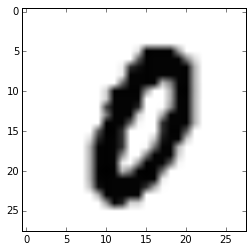

In [133]:
sample_distribution = lambda x: mnist_data(x)/255.
example = sample_distribution(1)[0]
example = np.reshape(example, [28,28])
plt.imshow(example, cmap='Greys')
plt.show()

In [160]:
#Training
tf.reset_default_graph()
np.random.seed(2)
dX = sample_distribution(1).shape[1]
dZ = 10
batch_size = 32
vae = VAE(dX, dZ)

tot_loss = 0
heartbeat = 100
losses = []
for i in range(3000):
    x = sample_distribution(batch_size)
    loss = vae.step(x, lr=1e-2)
    tot_loss += loss
    if i%heartbeat == 0:
        #clear_output()
        print i, tot_loss/heartbeat
        losses.append(tot_loss/heartbeat)
        sys.stdout.flush()
        tot_loss = 0
        mus, sigmas = vae.encode(x)
        #print np.mean(mus, axis=1)
        #print np.mean(sigmas, axis=1)

0 0.232293262482
100 5.26097732753
200 0.309061474502
300 0.291225523353
400 0.284149504006
500 0.282161239982
600 0.287046388686
700 0.285999472439
800 0.280439178646
900 0.296827653646
1000 0.297067195475
1100 0.280318080187
1200 0.285758688152
1300 0.297210303843
1400 0.283393908739
1500 0.281892277002
1600 0.272350639105
1700 0.274558444917
1800 0.269031436294
1900 0.270326709002
2000 0.273847526014
2100 0.282609712034
2200 0.275466653556
2300 0.28645879522
2400 0.273125647008
2500 0.276766355932
2600 0.285406601429
2700 0.269946943521
2800 0.266707397103
2900 0.266780179292


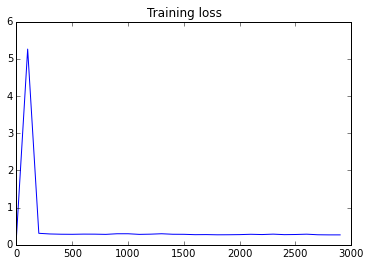

In [161]:
# Training plot
plt.title("Training loss")
plt.plot(np.arange(len(losses))*heartbeat, losses)
plt.show()

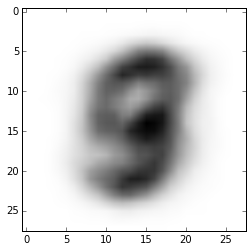

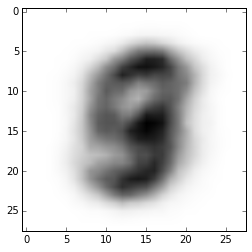

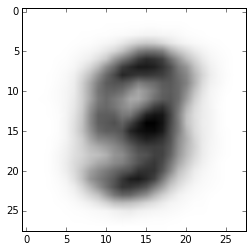

In [162]:
# Try sampling!
np.set_printoptions(suppress=True)
samples = vae.sample(3, noise=1.)
for samp in samples:
    example = np.reshape(samp, [28,28])
    #print example
    plt.imshow(example, cmap='Greys')
    plt.show()